In [2]:
using LinearAlgebra
using Flux
using DiffEqFlux
using OrdinaryDiffEq
using DiffEqSensitivity
using GalacticOptim
using Optimization
using OptimizationOptimisers
using Plots
using Zygote
using BenchmarkTools
using CUDA
using Printf
using MLUtils
using IterTools: ncycle
using BSON: @save, @load

include("src/equations/initial_functions.jl")
include("src/equations/equations.jl")
include("src/utils/graphic_tools.jl")
include("src/utils/generators.jl")
include("src/neural_ode/objectives.jl")
include("src/neural_ode/models.jl")
include("src/neural_ode/models/blocks.jl")
include("src/neural_ode/regularization.jl")
include("src/rom/pod.jl")
include("src/utils/processing_tools.jl")

Main.ProcessingTools

# FOM + ROM solutions

Compute some fom and rom solution u(t, x)

## Test various burgers resolution method for FOM

Experiments with different initial conditions: Gaussian random, high dimensional random, sin, exp, -x, etc.

In [3]:
t_max = 2.; # 6 (godunov)
t_min = 0.;
x_max = pi; # 2pi (godunov)
x_min = 0.;
t_n = 64;
x_n = 64;

nu = 0.04;

dt = round((t_max - t_min) / (t_n - 1), digits=8);
dx = round((x_max - x_min) / (x_n - 1), digits=8);

t = LinRange(t_min, t_max, t_n);
x = LinRange(x_min, x_max, x_n);

In [4]:
function animate_snapshot_prediction(u_pred, u, x, filename)
    t_n = 64
   
    anim = @animate for i ∈ 1:t_n
        plt = plot(x, u[:, i], label="u")
        plot!(plt, x, u_pred[:, i], linestyle=:dash, label="û")
        plot!(plt; xlims=(0., pi), ylims=(-2, 2.), dpi=300)
    end

    gif(anim, filename, fps = 15)
end

animate_snapshot_prediction (generic function with 1 method)

### Godunov

In [426]:
u0 = InitialFunctions.high_dim_random_init(t, x, 4);
# u0 = exp.(-16 .* (x.^2));
# u0 = InitialFunctions.advecting_shock(t, x, nu);
# u0 = random_init(t, x);
# u0 = InitialFunctions.random_gaussian_init(t, x, 0.25, 1.);
# u0 = -1 .* collect(x);

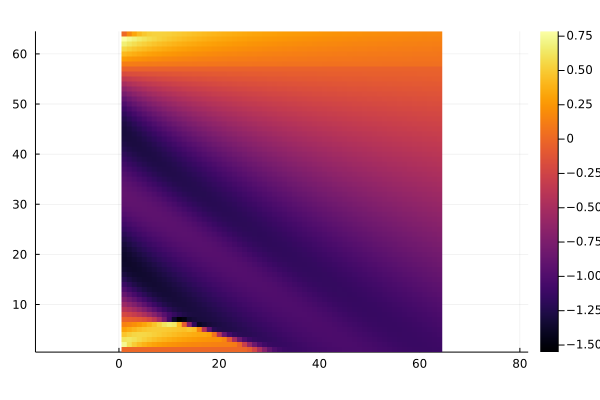

In [427]:
t1, u1 = Equations.get_burgers_godunov(t, dx, x_n, nu, u0[1, :]);
GraphicTools.show_state(u1, "") # need to reverse u, odesolver switch dimensions

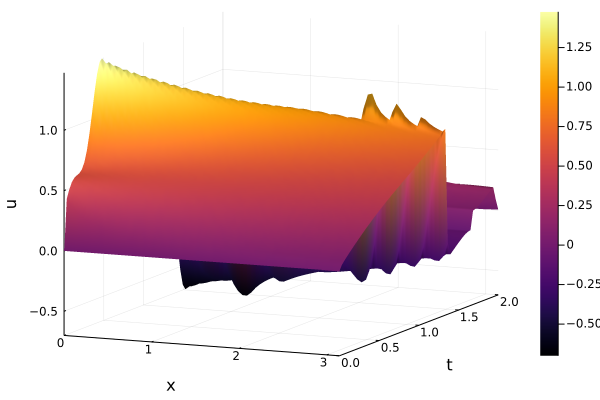

In [241]:
plot(x, t1, u1, st = :surface, xlabel = "x", ylabel = "t", zlabel = "u")
plot!(dpi=300)

In [ ]:
animate_snapshot_prediction(u1, u1, collect(LinRange(x_min, x_max, 64)), "snapshot_viscous_burgers_nu004_fps15.gif")

### CCDF

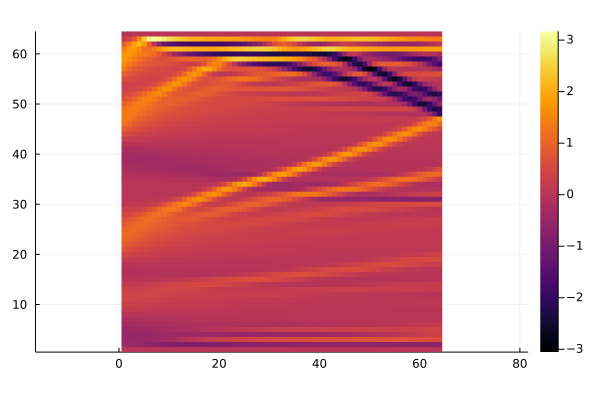

In [7]:
t2, u2 = Equations.get_burgers_ccdf(t, dx, x_n, nu, u0[1, :]);
GraphicTools.show_state(u2, "")

### Pseudo-spectral method

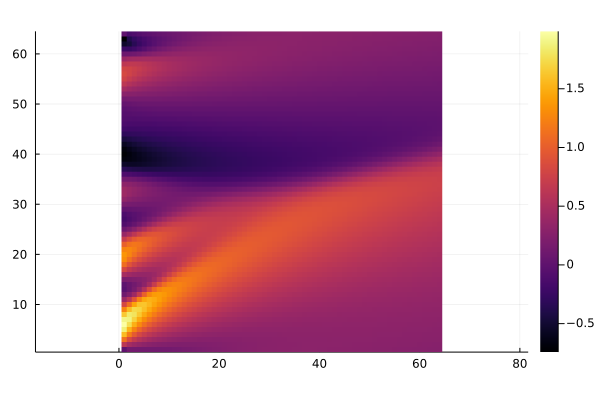

In [116]:
t3, u3 = Equations.get_burgers_fft(t, dx, x_n, nu, u0[1, :]);
GraphicTools.show_state(u3, "")

In [ ]:
plot(x, t, u3, st = :surface, xlabel = "t", ylabel = "x", zlabel = "u")
plot!(dpi=300)

### POD-GC

In [428]:
bas, ū = POD.generate_pod_basis(u1, true);
ϕ = bas.modes;
coeff = bas.coefficients;
tmp = ϕ[:, 1:3] * coeff[1:3, :] .+ ū;

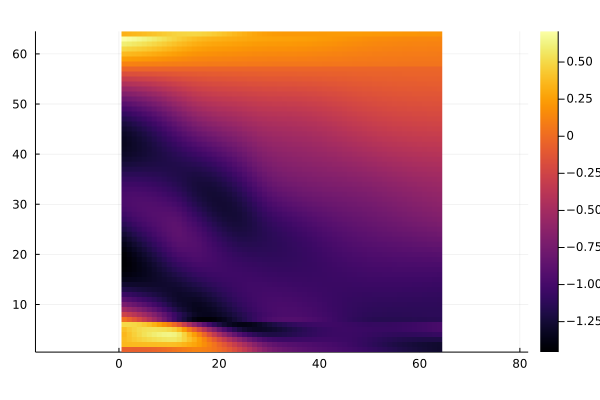

In [429]:
GraphicTools.show_state(tmp, "")

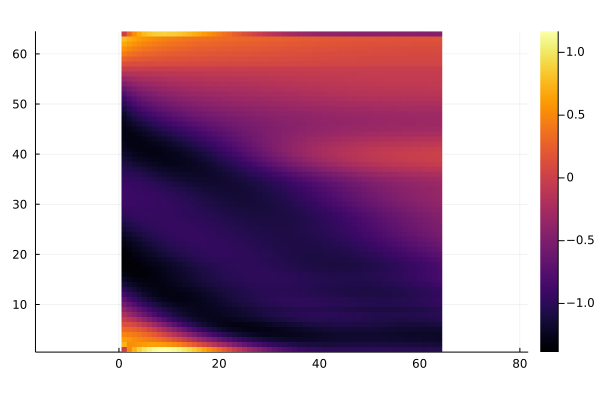

In [430]:
Ū = Equations.galerkin_projection(t, u1, ϕ[:, 1:20], nu, dx, dt);
GraphicTools.show_state(Ū, "")

## Analytical solution initial conditions

In [ ]:
#u0 = InitialFunctions.advecting_shock(t, x, nu);
u0 = exp.(-16 .* (x.^2));
t, u = Equations.get_burgers_fft(t, dx, x_n, nu, u0);
GraphicTools.show_state(u, "Snapshot")

In [ ]:
plot(t, x, u, st = :surface, xlabel = "t", ylabel = "x", zlabel = "u")
plot!(dpi=300)

---
# Generate data

In [317]:
n = 4;
snap_kwargs = repeat([(; t_max=2., t_min=0., x_max=1., x_min=0., t_n, x_n, nu=0.001, typ=3)], n);
init_kwargs = repeat([(; nu=0.001 )], n); # mu=0.25, sigma=1.
dataset_closure = Generator.generate_closure_dataset(n, 1, "", snap_kwargs, init_kwargs);
dataset_gp = Generator.generate_pod_gp(dataset_closure, 3, "./src/dataset/inviscid_burgers_advecting_shock_podgp_4_j173.jld2");

Generating snapshot 1...Done
Generating snapshot 2...Done
Generating snapshot 3...Done
Generating snapshot 4...Done
Generating pod-gp snapshot 1...E = 0.892493034468976...Done
Generating pod-gp snapshot 2...E = 0.892493034468976...Done
Generating pod-gp snapshot 3...E = 0.892493034468976...Done
Generating pod-gp snapshot 4...E = 0.892493034468976...Done


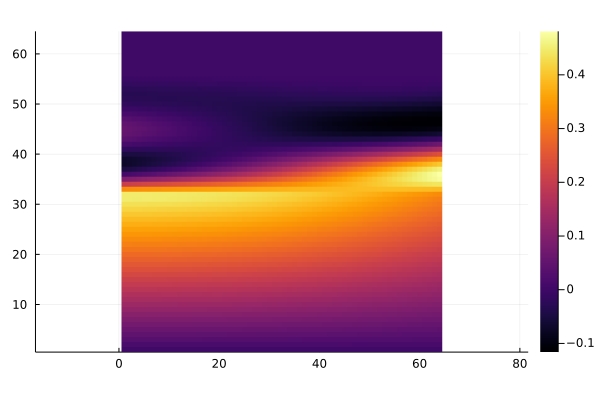

In [318]:
bas, ū = POD.generate_pod_basis(dataset_gp[1][4], true);
ϕ = bas.modes;
coeff = bas.coefficients;
tmp = ϕ[:, 1:3] * coeff[1:3, :] .+ ū;
Ū = Equations.galerkin_projection(t, dataset_gp[1][4], ϕ[:, 1:3], 0.001, dx, dt);
GraphicTools.show_state(Ū, "")

In [295]:
snap_kwargs = (; t_max, t_min, x_max, x_min, t_n, x_n, nu, typ=2);
init_kwargs = (; m=10);
dataset = Generator.generate_burgers_training_dataset(256, 2, 1, false, "./src/dataset/viscous_burgers_high_dim_m10_256_j173.jld2", "training_set", snap_kwargs, init_kwargs);
# dataset = Generator.read_dataset("./src/examples/burgers/dataset/viscous_burgers_high_dim_m10_256_j173.jld2")["training_set"];

Generating snapshot 1...

LoadError: InterruptException:

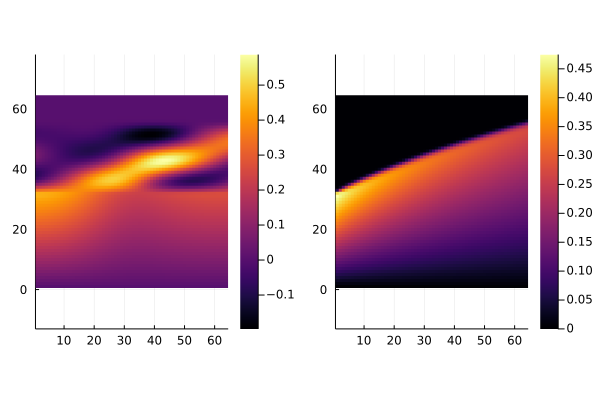

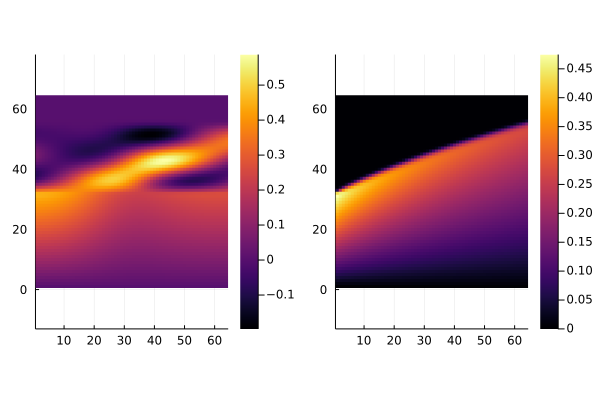

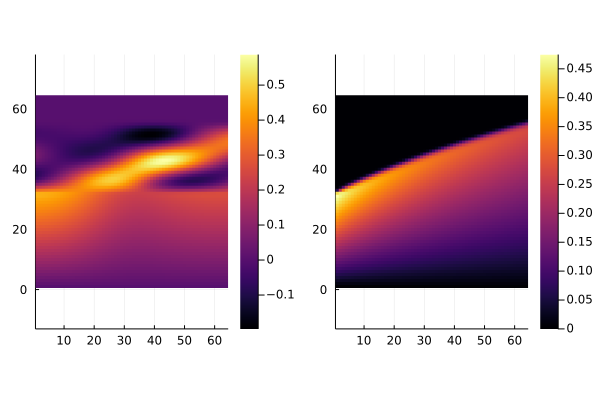

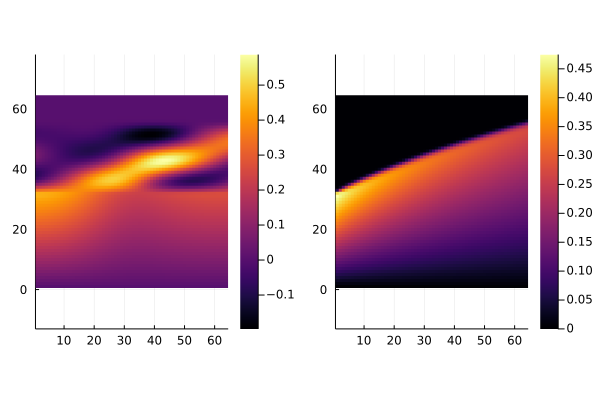

In [319]:
function check_training_dataset(dataset)
    for i in range(1, 4, step=1)
        _, b, _, d, _, _ = dataset[i];
        display(
            plot(
                GraphicTools.show_state(b, ""),
                GraphicTools.show_state(d, "");
                layout = (1, 2),
            )
        )
    end
end

check_training_dataset(dataset_gp)

## Experiment with different models

### Heat linear model

In [ ]:
t, init_set, true_set = ProcessingTools.process_dataset(high_dataset, false);
net = Models.HeatModel(x_n);
result = burgers_training(net, 100, init_set, true_set, t);

In [ ]:
K = reshape(result, (x_n, x_n))
t, u0, u = Generator.get_burgers_batch(t_max, t_min, x_max, x_min, t_n, x_n, nu, 2);
u_pred = Array(S(K, u0, t));  # S function at bottom of notebook

plot(
    GraphicTools.show_state(u, ""),
    GraphicTools.show_state(u_pred, ""),
    GraphicTools.show_state((u_pred .- u), "");
    layout = (1, 3),
)

##### Operator reconstructed

Visualize reconstructed operator and check efficiency to determine solution from unknown sample

In [ ]:
function f(u, K, t)
  return K * u
end

function S(net, u0, t)
  tspan = (t[1], t[end])
  prob = ODEProblem(ODEFunction(f), copy(u0), tspan, net)
  sol = solve(prob, Tsit5(), saveat=t, reltol=1e-8, abstol=1e-8)
end

In [ ]:
K = reshape(result, (x_n, x_n))
GraphicTools.show_state(reverse(K; dims = 1), "Operator K")

In [ ]:
t, u0, u = Generator.get_burgers_batch(t_max, t_min, x_max, x_min, t_n, x_n, nu, 2);
u_pred = Array(S(K, u0, t));
plot(
    GraphicTools.show_state(u, ""),
    GraphicTools.show_state(u_pred, "");
    layout = (1, 2),
)

## Analysis

In [ ]:
function test_simulation(net, result, n, typ)
    mse_tot = 0
    l1_tot = 0
    for i in n
        t, u0, u_true = Generator.get_burgers_batch(t_max, t_min, x_max, x_min, t_n, x_n, nu, typ);
        prob_neuralode = DiffEqFlux.NeuralODE(net, (t[1], t[end]), Tsit5(), saveat=t)
        u_pred = prob_neuralode(u0, result)

        mse_tot += Objectives.mseloss(u_pred, u_true)
        l1_tot += sum(abs.(u_pred .- u_true))
    end
    
    return mse_tot / n, l1_tot / n
end

--- 
# Training with flux

In [449]:
del_dim(x::Array) = reshape(x, (size(x)[1], size(x)[3], size(x)[4]))

del_dim (generic function with 1 method)

In [ ]:
function check_result(nn, res, typ)
    t, u0, u = Generator.get_burgers_batch(t_max, t_min, x_max, x_min, t_n, x_n, nu, typ);
    prob_neuralode = DiffEqFlux.NeuralODE(nn, (t[1], t[end]), Tsit5(), saveat=t)
    u_pred = prob_neuralode(add_dim(u0), res)
#     prob = ODEProblem{false}(nn, Nothing, (Nothing, Nothing));
#     u_pred = Array(solve(prob, Tsit5(), u0=add_dim(u0), p=p, abstol=1e-9, reltol=1e-9, saveat=t, sensealg=DiffEqSensitivity.BacksolveAdjoint()));
    
    plot(
        GraphicTools.show_state(u, ""),
        GraphicTools.show_state(hcat(u_pred.u...), ""),
        GraphicTools.show_err(hcat(u_pred.u...), u, "");
        layout = (1, 3),
    )
end

In [7]:
function training(model, epochs, dataset, opt, batch_size, ratio, noise=0., sol=Tsit5(), cuda=false)
   if cuda && CUDA.has_cuda()
      device = Flux.gpu
      CUDA.allowscalar(false)
      @info "Training on GPU"
  else
      device = Flux.cpu
      @info "Training on CPU"
  end

  # Monitoring
  ep = 0;
  count = 0;
  lval = 0.;

  @info("Loading dataset")
  (train_loader, val_loader) = ProcessingTools.get_data_loader_rom(dataset, batch_size, ratio, false, cuda);

  @info("Building model")
  model_gpu = model |> device;
  p, re = Flux.destructure(model_gpu);
  p = p |> device;

  net(u, p, t) = re(p)(u);
  g = (u, p, t) -> f(u);
  
  function predict_neural_ode(θ, x, t)
    tspan = (float(t[1]), float(t[end]));
    _prob = ODEProblem(net, x, tspan, θ);
    ŷ = device(solve(_prob, sol, u0=x, p=θ, abstol=1e-6, reltol=1e-6, saveat=t));
    return permutedims(del_dim(ŷ), (1, 3, 2));
  end

  function loss(θ, x, ȳ, y, t)
    x̂ = Reg.gaussian_augment(x, noise);
    ŷ = predict_neural_ode(θ, x̂, t[1]);
    l = Flux.mse(ȳ .+ ŷ, y)
    return l;
  end

  function val_loss(θ, x, ȳ, y, t)
    ŷ = predict_neural_ode(θ, x, t[1]);
    l = Flux.mse(ȳ .+ ŷ, y)
    return l;
  end

  function cb(θ, l)
    @show(l)
    count += 1;

    iter = (train_loader.nobs / train_loader.batchsize);
    if (count % iter == 0)
      ep += 1;
      count = 0;
      lval = 0;

      for (x, ȳ, y, t) in val_loader
        (x, ȳ, y, t) = (x, ȳ, y, t) |> device;
        lval += val_loss(θ, x, ȳ, y, t);
      end # 60

      lval /= (val_loader.nobs / val_loader.batchsize);
      @info("Epoch ", ep, lval);
    end

    return false
  end

  @info("Initiate training")
  @info("ADAMW")  # 70
  optf = OptimizationFunction((θ, p, x, ȳ, y, t) -> loss(θ, x, ȳ, y, t), Optimization.AutoZygote())
  optprob = Optimization.OptimizationProblem(optf, p)
  result_neuralode = Optimization.solve(optprob, opt, ncycle(train_loader, epochs), callback=cb)

  return re(result_neuralode.u), p, lval
end

training (generic function with 4 methods)

In [6]:
function main()
  batch_size = 16;
  epochs = 50;

  data = Generator.read_dataset("./src/examples/burgers/dataset/viscous_burgers_high_dim_m10_256_j173.jld2")["training_set"];
  opt = OptimizationOptimisers.ADAMW(0.001, (0.9, 0.999), 1e-7);
  model = Models.CNN2(9, [2, 2, 1]);
  K, p, _ = training(model, epochs, data, opt, batch_size, 0.75, 0.1, Tsit5());
  return K, p
end

K, p = main()

┌ Info: Training on CPU
└ @ Main In[5]:8
┌ Info: Loading dataset
└ @ Main In[5]:16


LoadError: BoundsError: attempt to access 2-element Vector{AbstractArray{Float64}} at index [3]

In [52]:
# @save "./src/examples/burgers/models/BurgersBasicAutoEncoderModel.bson" K
@load "./src/examples/burgers/models/cnn_viscous_256_3/burgers_e400_worker_85_iter_5.bson" K p

In [26]:
# add_dim(x::Array{Float64, 1}) = reshape(x, (size(x)[1], 1, 1, 1))
# add_dim(x::Array) = reshape(x, (size(x)[1], 1, 1, size(x)[2]))
# del_dim(x::Array) = reshape(x, (size(x)[1], size(x)[4], size(x)[5]))
add_dim(x::Array{Float64, 1}) = reshape(x, (size(x)[1], 1, 1))
add_dim(x::Array) = reshape(x, (size(x)[1], 1, size(x)[2]))
del_dim(x::Array) = reshape(x, (size(x)[1], size(x)[3], size(x)[4]))

del_dim (generic function with 1 method)

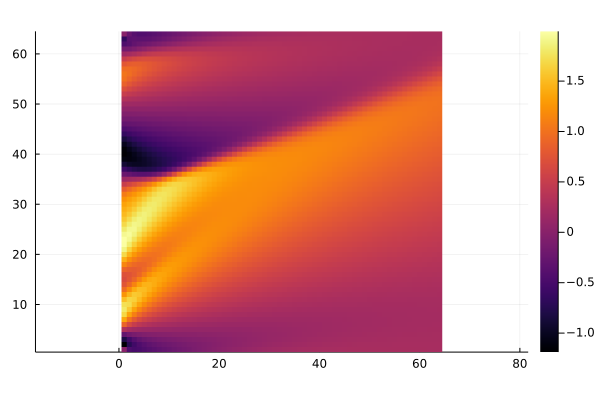

In [62]:
# check_result(K, p, 2)
init_kwargs = (; mu=10);
t, u0, u = Generator.get_burgers_batch(t_max, t_min, x_max, x_min, t_n, x_n, nu, 2, init_kwargs);
prob_neuralode = DiffEqFlux.NeuralODE(K, (t[1], t[end]), Tsit5(), saveat=t)
u_pred = prob_neuralode(add_dim(u0))
GraphicTools.show_state(u, "")

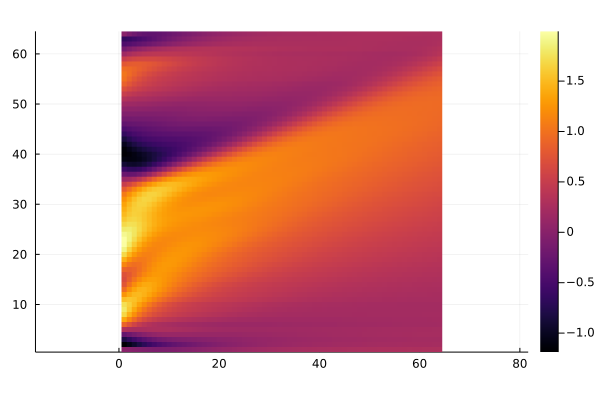

In [63]:
GraphicTools.show_state(hcat(u_pred.u...)[:, :], "") # [:, :, 1, 1]

In [64]:
Flux.mse(hcat(u_pred.u...)[:, :], u)

0.007774626767038285

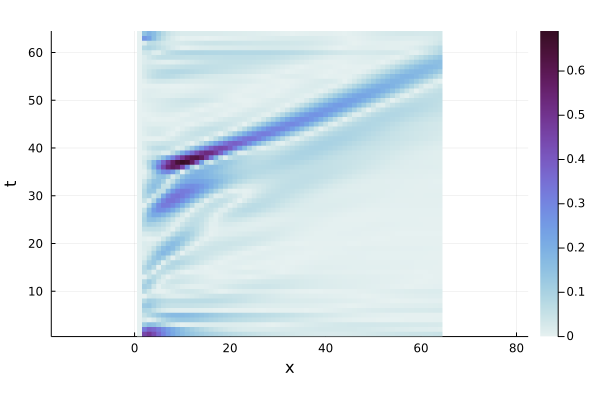

In [65]:
GraphicTools.show_err(hcat(u_pred.u...)[:, :], u, "")

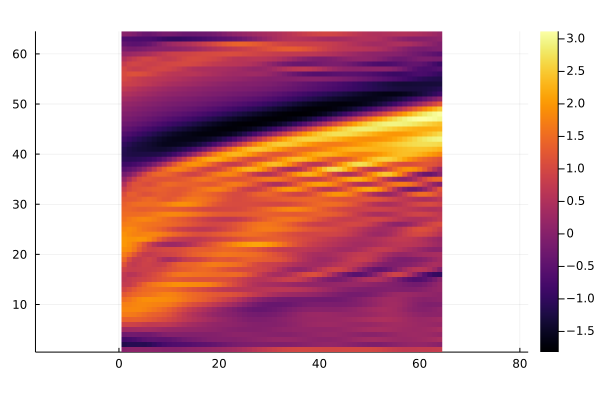

In [66]:
bas, ū = POD.generate_pod_basis(u, true);
ϕ = bas.modes;
Ū = Equations.galerkin_projection(t, u, ϕ[:, 1:end], 0.001, dx, dt);
GraphicTools.show_state(Ū, "")

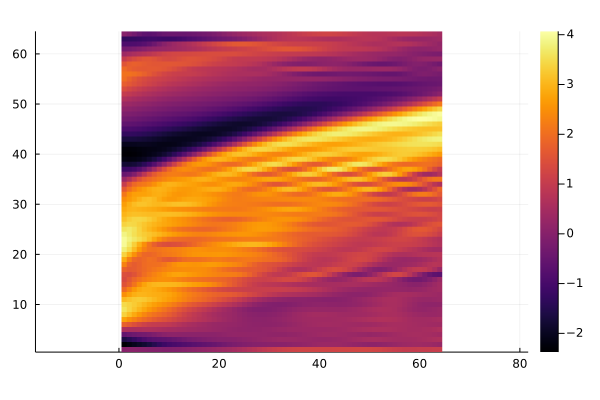

In [68]:
GraphicTools.show_state(Ū .+ hcat(u_pred.u...)[:, :], "")

In [ ]:
data = Generator.read_dataset("./src/examples/burgers/dataset/burgers_high_dim_training_set.jld2")["training_set"];
t, u0, u = ProcessingTools.process_dataset(data, false);
prob_neuralode = DiffEqFlux.NeuralODE(K, (t[1], t[end]), Rosenbrock23(), saveat=t);
i = 43
u_pred = prob_neuralode(u0[:, i], p);
display(
    plot(
        GraphicTools.show_state(u[:, i, :], ""),
        GraphicTools.show_state(hcat(u_pred.u...), ""),
        GraphicTools.show_err(hcat(u_pred.u...), u[:, i, :], "");
        layout = (1, 3),
    )
)